In [1]:
%load_ext lab_black
import networkx as nx
import community as community_louvain
import numpy as np
import functools
import webbrowser
from time import time
from IPython.core.display import display, HTML
from IPython.display import Javascript
from scipy.cluster.hierarchy import cut_tree, to_tree, leaves_list
from ipywidgets import Button, HBox, VBox, Output, Layout, Image
from ipyevents import Event

from krakow import krakow
from clustering_helpers import plot_dendrogram, normalized_dasgupta_cost

from scrape_helpers import scrape

from common import (
    save_graph,
    load_graph,
    id_to_url,
    id_to_thumbnail,
    get_from_playlists_from_time_range,
)

# import matplotlib.cm as cm
# import matplotlib.pyplot as plt

balance = 2.1
num_of_columns = 3
column_width = 1200 / num_of_columns

In [2]:
G = load_graph()

graph loaded


In [3]:
def window_open(_, url):
    webbrowser.open(url)
    # alternative is to use Javascript https://stackoverflow.com/a/61900572/11756613
    # and it works even when jupyter is remote
    # but here, when called by an event, it's broken for some reason

In [4]:
def sort_nodes_by_in_degree(G, nodes):
    recs = sorted(G.subgraph(nodes).in_degree(), key=lambda pair: pair[1], reverse=True)
    ids, scores = zip(*recs)
    return ids, scores


# def recommend(SubG, pickiness=0):
#     # this line recommends very normie videos
#     # it's equivalent to pickiness==0
#     # recs = sorted(SubG.in_degree(), key=lambda pair: pair[1], reverse=True)

#     # to be honest, I don't fully understand this part
#     # but it works better than the one on top:
#     # first limit recs only to the best ones
#     # this way, we'll omit most general normie recommendations later
#     best_recs = [node for node, in_degree in SubG.in_degree() if in_degree >= pickiness]
#     #     best_recs = [node for node, degree in SubG.degree() if degree >= pickiness]

#     ids, scores = sort_nodes_by_in_degree(SubG, best_recs)
#     return ids, scores


def display_video_links(G, ids, prefixes=None, show_first=15):
    if prefixes is None:
        prefixes = [""] * len(ids)

    for id_, prefix in list(zip(ids, prefixes))[:show_first]:
        if "title" not in G.nodes[id_] or G.nodes[id_]["title"] is None:
            scrape(id_, G)
            if "title" not in G.nodes[id_]:
                # scrapig failed - probably video is down
                continue

        url = id_to_url.format(id_)
        title = G.nodes[id_]["title"]

        image_url = id_to_thumbnail.format(id_)
        img = Image.from_url(image_url)
        event = Event(source=img, watched_events=["click"])
        func = functools.partial(window_open, url=url)
        event.on_dom_event(func)
        display(img)
        print(title)
        # display(HTML(f"""<a href="{url}">{prefix} {title}</a>"""))
        # display(HTML(f"""<a href="{url}"><img src="{image_url}"></a>"""))
        # display(HTML(f"""<textarea rows="3">{prefix} {title}</textarea>"""))
        print()
        print()

    save_graph(G)

In [5]:
seconds_in_year = 60 * 60 * 24 * 365
start_time = time() - seconds_in_year * 3
sources = get_from_playlists_from_time_range(G, start_time)
print("sources: ", len(sources))

RecentDirected = G.edge_subgraph(G.out_edges(sources))

# RecentDirectedNeighborhood = G.edge_subgraph(G.out_edges(RecentDirected.nodes))
# Recent = RecentDirectedNeighborhood.to_undirected()
Recent = RecentDirected.to_undirected()

print("number of videos: ", Recent.number_of_nodes())

sources:  693
number of videos:  10119


In [6]:
# choose only the biggest connected component
components = sorted(nx.connected_components(Recent), key=len, reverse=True)
# for el in components[:5]:
#     print(len(el))
main_component = components[0]
Main = Recent.subgraph(main_component)

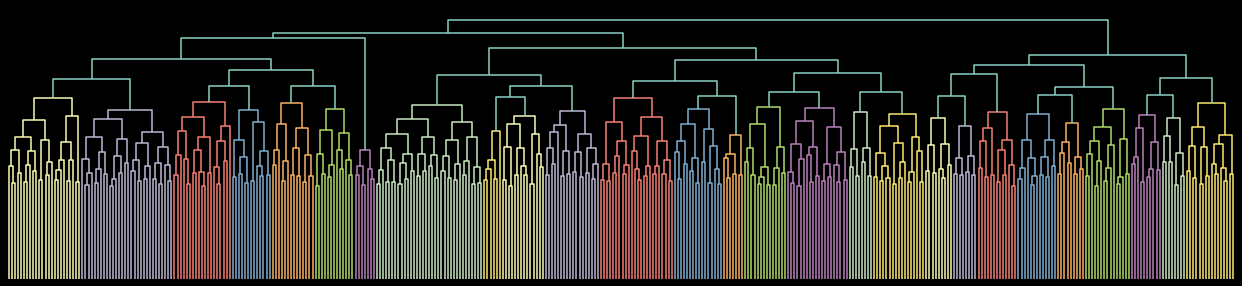

In [7]:
D = krakow(Main, balance=balance)

tree = to_tree(D)

plot_dendrogram(D, clusters_limit=400, width=22)

In [8]:
# normalized_dasgupta_cost(Main, D)

In [9]:
layout = Layout(width=f"{column_width}px")
outputs = [Output(layout=layout) for _ in range(num_of_columns)]

whole_output = HBox(outputs)

In [10]:
main_ids_list = np.array(Main.nodes)


def split_into_n_children(tree, n):
    children = [tree]

    while len(children) < n:
        index_of_biggest = np.argmax([child.count for child in children])
        to_split = children[index_of_biggest]
        splitten = [to_split.left, to_split.right]
        children[index_of_biggest : index_of_biggest + 1] = splitten
        # print([child.count for child in children])

    return children


def update_displayed_videos():
    global children
    try:
        children = split_into_n_children(tree, n=num_of_columns)
        clusters = [child.pre_order() for child in children]

    except AttributeError as e:
        print("already on the lowest cluster")
        # maybe log into some additional message output
        return

    for output, cluster in zip(outputs, clusters):
        output.clear_output(wait=True)

        with output:
            video_ids_in_cluster = main_ids_list[cluster]
            ids, scores = sort_nodes_by_in_degree(RecentDirected, video_ids_in_cluster)
            display_video_links(G, ids)  # , scores)

In [11]:
def choose_column(event, i):
    global tree
    tree = children[i]
    update_displayed_videos()


for i, output in enumerate(outputs):
    event = Event(source=output, watched_events=["auxclick"])
    func = functools.partial(choose_column, i=i)
    event.on_dom_event(func)

In [12]:
update_displayed_videos()
whole_output